# Generating a MIDI music file from a time series: a mostly useless but quite cool routine
*Rémy Lapere - eScience course - 8/11/2022*

The key library for that is miditime. Then, all you need to do is build an array specifying (time, pitch, velocity, duration) for every time step. The pitch is based on the values in the time series.

In this example we will compose the original music: *Evolution of annual mean temperature in the Arctic in C minor* from NorESM CMIP6 data in scenario ssp585.

Main steps:
- define the minimum and maximum pitch
- rescale the data to this range
- apply a key to obtain a nicer harmony
- manipulate the data to avoid repetitions and generate info on time, velocity and duration
- generate a MIDI file
- export that MIDI file to your favorite software

For a more comprehensive reference see *de Mora et al., 2020* - https://gc.copernicus.org/articles/3/263/2020/

In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import pandas as pd
from miditime.miditime import MIDITime
import matplotlib.pyplot as plt

Define minimum and maximum notes for the song (middle C is 60, below 25 is very low, higher than 100 is very high). A unit corresponds to a semitone.

In [2]:
minpitch, maxpitch = 36, 60

Load data from pangeo (here surface temperature in historical and ssp585 experiments)

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id=['tos'], member_id=['r1i1p1f1'], source_id=['NorESM2-LM'], experiment_id=['historical','ssp585'], table_id=['Omon'])

In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
dataset_list = list(dset_dict.keys())
dataset_list

['CMIP.NCC.NorESM2-LM.historical.Omon.gn',
 'ScenarioMIP.NCC.NorESM2-LM.ssp585.Omon.gn']

In [7]:
AR_hist = dset_dict[dataset_list[0]] # historical experiment
AR_fut5 = dset_dict[dataset_list[1]] # ssp585 experiment
AR_hist

<xarray.Dataset>
Dimensions:             (i: 360, j: 385, time: 1980, bnds: 2, member_id: 1,
                         vertices: 4)
Coordinates:
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
    latitude            (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id           (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 185, 385, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(385, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(385, 360, 4), meta=np.ndarray>
Attributes: (12/54)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     430335.0
    ...                        ...
    variable_id:               tos
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/1227f743-6dba-4739-aa71-d8691166a...
    version_id:                v20190815
    intake_esm_varname:        ['tos']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.Omon.gn

Extract the area/period of interest, and rescale the time series to the range of authorized pitch

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

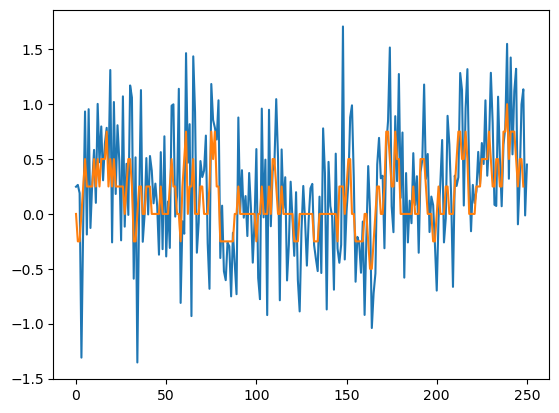

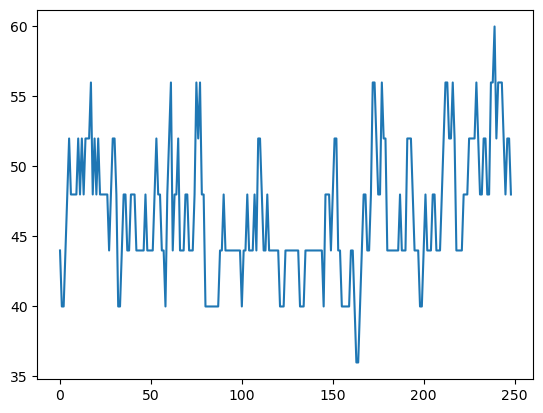

In [112]:
def ext_nao():
    """
    function for extraction area/period of interest
    and concatenate into a single numpy
    """

    north_hist = AR_hist.sel(lat=slice(59,63),lon=slice(360-25,360-15),time=slice('1951-01-01','1980-12-31'))
    north_hist = north_hist.reduce(np.mean,dim=('lat','lon')).squeeze()
    south_hist = AR_hist.sel(lat=slice(36,40),lon=slice(360-30,360-20),time=slice('1951-01-01','1980-12-31'))
    south_hist = south_hist.reduce(np.mean,dim=('lat','lon')).squeeze()
    
    north_ = AR_hist.sel(lat=slice(59,63),lon=slice(360-25,360-15))#,time=slice('1950-01-01','2014-12-31'))
    north_ = north_.reduce(np.mean,dim=('lat','lon')).squeeze()
    south_ = AR_hist.sel(lat=slice(36,40),lon=slice(360-30,360-20))#,time=slice('1950-01-01','2014-12-31'))
    south_ = south_.reduce(np.mean,dim=('lat','lon')).squeeze()
    
    north_585 = AR_fut5.sel(lat=slice(59,63),lon=slice(360-25,360-15))
    north_585 = north_585.reduce(np.mean,dim=('lat','lon')).squeeze()
    south_585 = AR_fut5.sel(lat=slice(36,40),lon=slice(360-30,360-20))
    south_585 = south_585.reduce(np.mean,dim=('lat','lon')).squeeze()
    
    Am = north_hist.psl.groupby('time.month').mean('time')
    Bm = south_hist.psl.groupby('time.month').mean('time')

    sigAm = north_hist.psl.groupby('time.month').std('time')
    sigBm = south_hist.psl.groupby('time.month').std('time')
  
    B585 = (south_585-np.tile(Bm.values,86))/np.tile(sigBm.values,86)
    A585 = (north_585-np.tile(Am.values,86))/np.tile(sigAm.values,86)
    
    Bh = (south_-np.tile(Bm.values,165))/np.tile(sigBm.values,165)
    Ah = (north_-np.tile(Am.values,165))/np.tile(sigAm.values,165)
    
    naoh = Ah-Bh
    nao585 = A585-B585
    
    naoh = naoh.where(naoh.time.dt.month.isin([1,2,12]), drop=True)
    naoh585 = nao585.where(nao585.time.dt.month.isin([1,2,12]), drop=True)

    exth = naoh.resample(time='1Y').mean()
    ext585 = nao585.resample(time='1Y').mean()

    return xr.concat([exth,ext585],dim='time')
    
n585 = ext_nao()
n585 = n585.psl.values
plt.plot(n585)
n585 = (n585/0.25).astype(int)*0.25
n585 = moving_average(n585,3)
n585 = (n585/0.25).astype(int)*0.25
plt.plot(n585)
plt.show()

mini = np.min(n585)
maxi = np.max(n585)

# normalize data to [0,1]
n585_ = (n585-mini)/(maxi-mini)

# apply a mapping to the range of authorized min/max pitch
n585_ = minpitch+n585_*(maxpitch-minpitch)

# if you want to associate increasing temperature with lower pitch notes
#n585_ = minpitch-n585_+maxpitch

# make it an integer type because MIDI only handles semitones
n585_ = n585_.astype(int)

plt.plot(n585_)
plt.show()

# store notes into a data set along with time steps
df_ = pd.DataFrame({'val':n585_,'step':range(len(n585_))})

In [19]:
def ext_pdo():
    """
    function for extraction area/period of interest
    and concatenate into a single numpy
    """

    north_hist = AR_hist.sel(j=slice(20*4,50*4),i=slice(160,360-135),time=slice('1951-01-01','1980-12-31'))
    north_hist = north_hist.reduce(np.mean,dim=('j','i')).squeeze()
    pac = AR_hist.sel(j=slice(20,50),i=slice(160,360-135))
    pac = pac.reduce(np.mean,dim=('j','i')).squeeze()
    glob = AR_hist.reduce(np.mean,dim=('j','i')).squeeze()
    
    pac5 = AR_fut5.sel(j=slice(20,50),i=slice(160,360-135))
    pac5 = pac5.reduce(np.mean,dim=('j','i')).squeeze()
    glob5 = AR_fut5.reduce(np.mean,dim=('j','i')).squeeze()

    
    anog5 = glob5.tos-north_hist.tos
    pdo5 = pac5-anog5
    
    anog = glob.tos-north_hist.tos
    pdo = pac-anog
    
    exth = np.array([np.mean(pdo.tos.values[12*i:12*(i+1)]) for i in range(165)])
    exth5 = np.array([np.mean(pdo5.tos.values[12*i:12*(i+1)]) for i in range(85)])

    return xr.concat([exth,ext5h],dim='time')
    
n585 = ext_pdo()
plt.plot(n585)
n585 = (n585/0.25).astype(int)*0.25
n585 = moving_average(n585,3)
n585 = (n585/0.25).astype(int)*0.25
plt.plot(n585)
plt.show()

mini = np.min(n585)
maxi = np.max(n585)

# normalize data to [0,1]
n585_ = (n585-mini)/(maxi-mini)

# apply a mapping to the range of authorized min/max pitch
n585_ = minpitch+n585_*(maxpitch-minpitch)

# if you want to associate increasing temperature with lower pitch notes
#n585_ = minpitch-n585_+maxpitch

# make it an integer type because MIDI only handles semitones
n585_ = n585_.astype(int)

plt.plot(n585_)
plt.show()

# store notes into a data set along with time steps
df_ = pd.DataFrame({'val':n585_,'step':range(len(n585_))})

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'ext5h' is not defined

- So far we have a list of notes and time steps... but not all the notes can work together in harmony.

- In the next part we interpolate the notes to the nearest "authorized" note according to the chosen key.

- Here the example key is C minor, i.e. authorized notes are: C,Eb,G.

- Our 'zero' note is 24 which corresponds to C, 2 octaves (1 octave is 12 semitones) below middle C.

- Therefore the list of authorized notes is {0,3,7}mod(12)

In [113]:
def _to_chords_(df, key):
    """
    function to map the original notes to the defined key
    """
    notes = range(len(np.arange(minpitch,maxpitch+1,1)))
    notes_ = np.arange(minpitch,maxpitch+1,1)
    dom = np.mod(notes,12)==key[0]
    tir = np.mod(notes,12)==key[1]
    qui = np.mod(notes,12)==key[2]
    auth = dom+tir+qui
    auth_notes = notes_[auth]
    notin = df.val.values
    i=0
    for nn in notin:
        dist = np.abs(auth_notes-nn)
        tru_note = auth_notes[np.argmin(dist)]
        notin[i] = tru_note
        i=i+1
    df['val'] = notin
    return df

In [114]:
def extract_sdt(indata,kkeys):
    """
    function to aggregate consecutive notes
    and includes info on duration/velocity
    """
    didif = [indata['step'].values[0]]
    indata = _to_chords_(indata,kkeys)
    for i in np.arange(1,len(indata.val.values)):
        if indata['val'].values[i]==indata['val'].values[i-1]:
            didif = np.append(didif,indata['step'].values[i-1])
        else:
            didif = np.append(didif,indata['step'].values[i])
    indata['dif'] = didif
    steps = indata.groupby(['dif','val'],as_index=False).count().step.values
    vals = (indata.groupby(['dif','val'],as_index=False).mean().val.values).astype(int)
    new_df = pd.DataFrame({'note':vals,
                       'steps':np.cumsum(steps)-np.min(np.cumsum(steps)),
                       'duration':np.append(steps[1:],2),
                      'force':np.repeat(127,len(steps))})
    for j in np.arange(1,len(new_df.note.values)):
        if new_df.note.values[j] == new_df.note.values[j-1]:
            new_df.steps[j] = new_df.steps.values[j-1]
    dur = new_df.groupby(['steps'],as_index=False).sum().duration.values
    new_df = new_df.drop_duplicates(['steps','note'])
    new_df.duration = dur
    new_df['force'] = np.linspace(100,126,len(dur)).astype(int)
    new_df = new_df[['steps','note','force','duration']]
    return new_df

ext_mus = extract_sdt(df_,[0,3,7])
# save to csv
ext_mus.to_csv('arc_tas_music_585')

In [115]:
def to_midi(infile,nm):
    """
    function to convert the data to MIDI file
    """
    mymidi = MIDITime(160, nm+'.mid') # 160 is the tempo
    music = np.array(pd.read_csv(infile,skiprows=1,header=None,index_col=0)).tolist()
    # Add a track with those notes                                                                                                                                                                              
    mymidi.add_track(music)
    # Output the .mid file                                                                                                                                                                                      
    mymidi.save_midi()
    
# the exported MIDI file can be played with a dedicated audio player (e.g. GarageBand)
to_midi('arc_tas_music_585','arc_tas_music_585')

43 0 2 100
39 2 1 100
43 3 1 100
48 4 1 100
51 5 2 100
48 7 3 101
51 10 1 101
48 11 1 101
51 12 1 101
48 13 2 101
51 15 2 102
55 17 1 102
48 18 1 102
51 19 1 102
48 20 1 103
51 21 2 103
48 23 4 103
43 27 1 103
48 28 2 103
51 30 1 104
48 31 2 104
39 33 1 104
43 34 2 104
48 36 2 104
43 38 2 105
48 40 3 105
43 43 4 105
48 47 2 105
43 49 3 106
48 52 1 106
51 53 2 106
48 55 2 106
43 57 1 106
39 58 1 107
48 59 1 107
51 60 1 107
55 61 1 107
43 62 2 108
48 64 1 108
51 65 2 108
43 67 3 108
48 70 2 108
43 72 2 109
48 74 1 109
55 75 1 109
51 76 1 109
55 77 2 109
48 79 2 110
39 81 8 110
43 89 1 110
48 90 2 110
43 92 8 111
39 100 2 111
43 102 1 111
48 103 2 111
43 105 2 111
48 107 1 112
43 108 2 112
51 110 1 112
48 111 2 112
43 113 1 113
48 114 2 113
43 116 6 113
39 122 3 113
43 125 8 113
39 133 3 114
43 136 9 114
39 145 2 114
48 147 2 114
43 149 1 114
48 150 2 115
51 152 2 115
43 154 2 115
39 156 5 115
43 161 1 116
39 162 2 116
36 164 1 116
39 165 1 116
43 166 2 116
48 168 2 117
43 170 1 117
48 17